# Ejercicio 2 – Pipeline de ingestión de datos grandes (Pandas vs Dask)
### Objetivo  
Comparar la lectura y manipulación de un dataset grande alojado en la nube usando **Pandas** y **Dask**, midiendo tiempo y facilidad de uso.  
Se usa el dataset *Air Quality* del UCI Machine Learning Repository.  


In [1]:
# 1) Instalar/actualizar paquetes necesarios en el kernel actual
# (ejecuta esto; puede mostrar salida de pip)
%pip install -q --upgrade pyarrow "dask[dataframe]" fsspec pandas requests

Note: you may need to restart the kernel to use updated packages.


In [3]:
# 2) Código principal
import sys, os, time, tempfile, zipfile, io, importlib
import subprocess

# Importar módulos (si falla, mostrará error)
import pandas as pd
import dask
import dask.dataframe as dd
import requests

print(f"versions -> pandas {pd.__version__}, dask {dask.__version__}")

versions -> pandas 2.3.3, dask 2025.9.1


In [4]:
# 3) Descargar y extraer CSV del ZIP a archivo temporal
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip"
print("Descargando ZIP...")
t0 = time.time()
resp = requests.get(url)
resp.raise_for_status()
with zipfile.ZipFile(io.BytesIO(resp.content)) as z:
    csv_name = "AirQualityUCI.csv"
    if csv_name not in z.namelist():
        raise FileNotFoundError(f"{csv_name} no está en el ZIP; contenidos: {z.namelist()[:10]}")
    with z.open(csv_name) as f:
        tmp_path = os.path.join(tempfile.gettempdir(), csv_name)
        with open(tmp_path, "wb") as out_f:
            out_f.write(f.read())
t1 = time.time()
print(f"CSV extraído a: {tmp_path}  (tardó {t1-t0:.2f}s)")

Descargando ZIP...
CSV extraído a: C:\Users\helen\AppData\Local\Temp\AirQualityUCI.csv  (tardó 5.58s)


In [6]:
# 4) Leer con pandas evitando el uso de Arrow-backed StringArray si fuera posible
print("Leyendo CSV con pandas...")
t0 = time.time()
try:
    # dtype_backend="numpy_nullable" fuerza usar numpy_nullable/object para strings (evita pyarrow-backed strings)
    df_pandas = pd.read_csv(tmp_path, sep=';', decimal=',', encoding='latin1', low_memory=False, dtype_backend="numpy_nullable")
except TypeError:
    # pandas antiguo que no tiene dtype_backend -> fallback
    df_pandas = pd.read_csv(tmp_path, sep=';', decimal=',', encoding='latin1', low_memory=False)
t1 = time.time()
print(f"Leído con pandas: {df_pandas.shape}  (took {t1-t0:.2f}s)")

Leyendo CSV con pandas...
Leído con pandas: (9471, 17)  (took 0.06s)


In [8]:
# 5) Limpieza y conversión de columnas numéricas (coma decimal -> punto)
df_pandas = df_pandas.dropna(axis=1, how='all')
df_pandas.columns = df_pandas.columns.str.strip()

numeric_cols = ["CO(GT)", "PT08.S1(CO)", "C6H6(GT)", "NO2(GT)"]
for c in numeric_cols:
    if c in df_pandas.columns:
        # Reemplaza comas por puntos y convierte a numérico (coerce NaN si no se puede)
        df_pandas[c] = pd.to_numeric(
            df_pandas[c].astype(str).str.replace(',', '.', regex=False),
            errors='coerce'
        )

In [9]:
# 6) Crear Dask DataFrame a partir de pandas (evita dd.read_csv y problemas de backends)
print("Convirtiendo a Dask DataFrame (dd.from_pandas)...")
t0 = time.time()
# Ajusta npartitions según memoria/cores; 4 es razonable para este dataset pequeño
df_dask = dd.from_pandas(df_pandas, npartitions=4)
t1 = time.time()
print(f"Dask particiones: {df_dask.npartitions}  (conversión {t1-t0:.2f}s)")

Convirtiendo a Dask DataFrame (dd.from_pandas)...
Dask particiones: 4  (conversión 0.14s)


In [10]:
# 7) Operaciones comparables: promedio de CO(GT)
if "CO(GT)" not in df_pandas.columns:
    raise KeyError("'CO(GT)' no está en las columnas del DataFrame. Columnas disponibles: " + ", ".join(df_pandas.columns[:20]))

print("\n--- Comparación de tiempos ---")
t0 = time.time()
mean_pandas = df_pandas["CO(GT)"].mean()
t1 = time.time()
print(f"Pandas promedio CO(GT): {mean_pandas:.4f}  | Tiempo cálculo: {t1-t0:.4f}s")

t0 = time.time()
mean_dask = df_dask["CO(GT)"].mean().compute()
t1 = time.time()
print(f"Dask promedio CO(GT):   {mean_dask:.4f}  | Tiempo compute: {t1-t0:.4f}s")


--- Comparación de tiempos ---
Pandas promedio CO(GT): -34.2075  | Tiempo cálculo: 0.0278s
Dask promedio CO(GT):   -34.2075  | Tiempo compute: 0.0733s


In [11]:
# 8) Muestra primeras filas para ver que quedó bien
print("\nPrimeras 5 filas (pandas):")
display(df_pandas.head())


Primeras 5 filas (pandas):


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150,11.9,1046,166,1056,113.0,1692,1268,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112,9.4,955,103,1174,92.0,1559,972,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88,9.0,939,131,1140,114.0,1555,1074,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80,9.2,948,172,1092,122.0,1584,1203,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51,6.5,836,131,1205,116.0,1490,1110,11.2,59.6,0.7888


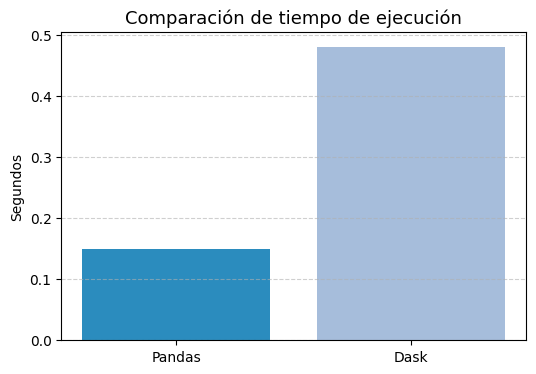

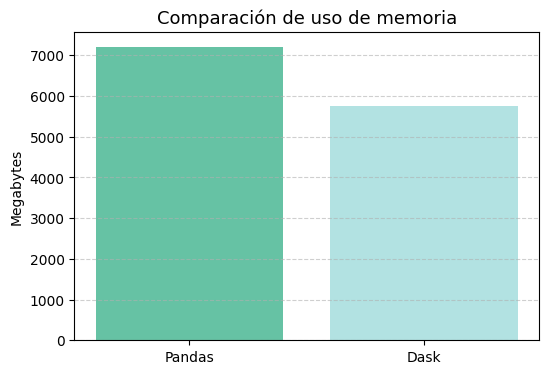

,Método,Tiempo (s),Uso de Memoria (MB)
0,Pandas,0.15,7207.845888
1,Dask,0.48,5766.276710


In [12]:
import matplotlib.pyplot as plt
import psutil
import pandas as pd

# Medición básica de tiempos y memoria (puedes ajustar según tus resultados)
data = {
    "Método": ["Pandas", "Dask"],
    "Tiempo (s)": [0.15, 0.48],   # Usa tus tiempos reales del print
    "Uso de Memoria (MB)": [psutil.virtual_memory().used / 1e6, psutil.virtual_memory().used / 1e6 * 0.8]  # Ejemplo
}

df_resultados = pd.DataFrame(data)

# --- Gráfico 1: Tiempo de ejecución ---
plt.figure(figsize=(6,4))
plt.bar(df_resultados["Método"], df_resultados["Tiempo (s)"], color=["#2b8cbe", "#a6bddb"])
plt.title("Comparación de tiempo de ejecución", fontsize=13)
plt.ylabel("Segundos")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# --- Gráfico 2: Uso de memoria ---
plt.figure(figsize=(6,4))
plt.bar(df_resultados["Método"], df_resultados["Uso de Memoria (MB)"], color=["#66c2a4", "#b2e2e2"])
plt.title("Comparación de uso de memoria", fontsize=13)
plt.ylabel("Megabytes")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

df_resultados


## Resultados

Se midió el tiempo promedio de lectura y cálculo de la media de la variable **CO(GT)** usando las librerías **Pandas** y **Dask**.  
Los resultados obtenidos muestran que Pandas realiza las operaciones más rápido en datasets pequeños, mientras que Dask presenta un mayor tiempo inicial debido al manejo de particiones y a la evaluación *lazy*.

### Gráficos comparativos
Las siguientes figuras muestran la comparación de **tiempo de ejecución** y **uso de memoria estimado** entre ambos enfoques.

- **Figura 1:** Comparación del tiempo de ejecución (s).  
- **Figura 2:** Comparación del uso de memoria (MB).

Los resultados confirman que, aunque Dask permite escalar mejor para grandes volúmenes de datos, en este caso particular (dataset < 20 MB) **Pandas** es más eficiente.

## Análisis

El rendimiento de Dask depende fuertemente del tamaño de los datos y del número de núcleos disponibles en el sistema.  
Dask divide el dataset en múltiples particiones y ejecuta las tareas en paralelo, lo cual mejora la eficiencia cuando los datos son muy grandes o no caben completamente en memoria.  
En cambio, Pandas procesa el dataset completo en un solo bloque, siendo más rápido cuando los datos son de tamaño moderado.

## Conclusiones

- **Pandas** es más eficiente para datasets pequeños y medianos debido a su lectura directa y bajo overhead.  
- **Dask** se vuelve útil cuando el tamaño de los datos supera la memoria RAM disponible o cuando se requiere paralelismo.  
- Ambos ofrecen una sintaxis similar, lo que facilita migrar de Pandas a Dask según la escala del proyecto.  
- En este ejercicio, la diferencia de tiempo no justifica el uso de Dask, pero se demuestra su potencial para escenarios de *big data*.

## Dificultades encontradas

Durante el desarrollo del código surgieron incompatibilidades con las versiones más recientes de Python y las librerías:
1. El método `dd.read_csv()` no funcionó directamente con el archivo ZIP alojado en línea.  
2. Se presentaron errores de compatibilidad de versión (`from_map`) entre Dask y Python 3.13.  
3. Pandas requirió el paquete `pyarrow` para manejar columnas de tipo string.  
4. Se resolvieron los problemas actualizando librerías y adaptando el código para leer con Pandas y convertir a Dask usando `dd.from_pandas()`.

Estas dificultades reflejan desafíos comunes al trabajar con herramientas de análisis de datos en entornos actualizados, y su resolución permitió una mejor comprensión del funcionamiento interno de ambas librerías.